# HSN619 - Project Assignment
**Network Dynamics in Citation Graphs**
---
---
Name- *Puneeth Vishisth Raavi*

Enrolment No- *21322024*

## Import modules

In [1]:
!pip install powerlaw

In [2]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import powerlaw
from random import sample

# 1. Data and Network Formation

---


In [3]:
# Load the data file
network_path = "/content/Node_Node.txt"
attribute_path = "/content/Node_Dates.txt"

# Read the file into a workable pandas DataFrame
network_data = pd.read_csv(network_path, sep='\t', names=['SRC', 'DST'], skiprows=4)
attribute_data = pd.read_csv(attribute_path, sep='\t', names=['Node ID', 'Year'], skiprows=1)

In [4]:
# Create Directed network
G = nx.DiGraph()

for _, row in network_data.iterrows():
    G.add_edge(row['SRC'], row['DST'])
print(f"Total Nodes: {G.number_of_nodes()}")
print(f"Total Edges: {G.number_of_edges()}")

Total Nodes: 27770
Total Edges: 352807


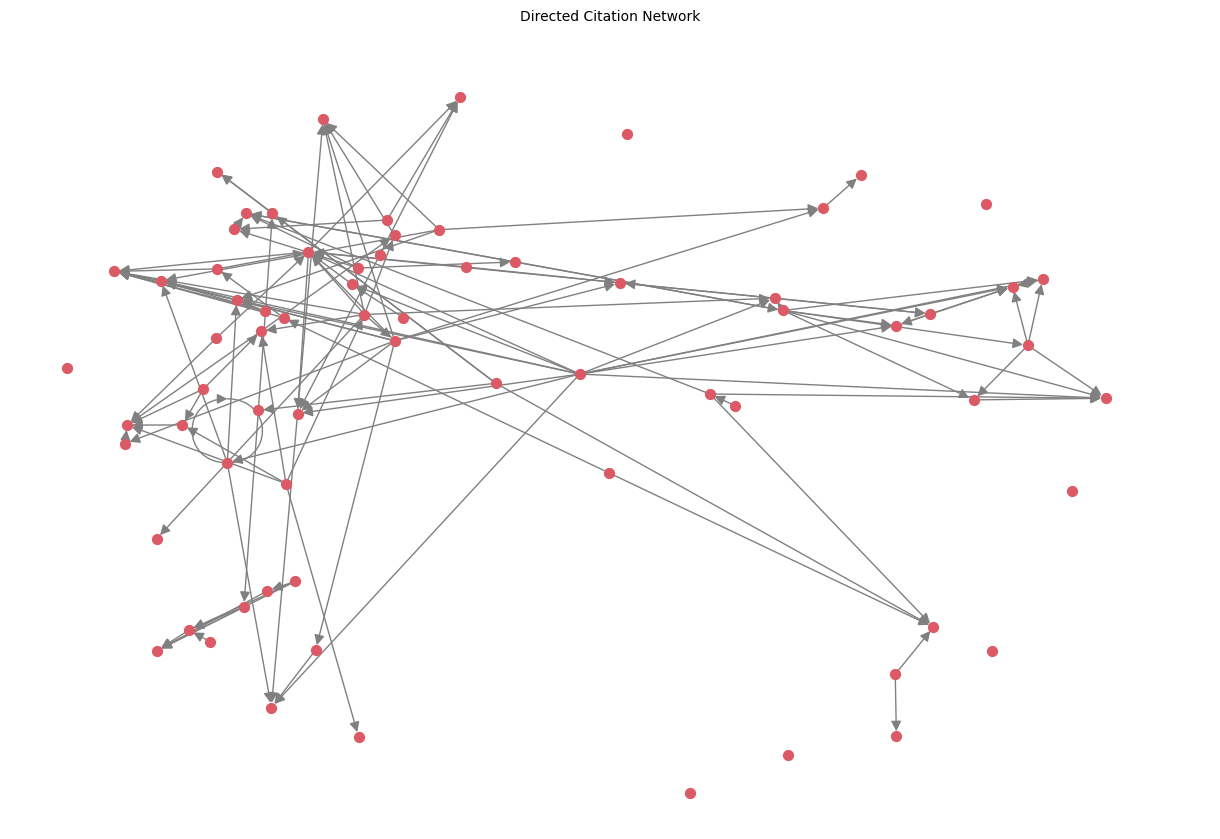

In [5]:
# remove randomly selected nodes for better visualisation
betweeness_G = G.copy()
num_to_remove = int(len(betweeness_G) / 1.2)
nodes = sample(list(betweeness_G.nodes), num_to_remove)
betweeness_G.remove_nodes_from(nodes)

# remove low-degree nodes
low_degree = [n for n, d in betweeness_G.degree() if d < 10]
betweeness_G.remove_nodes_from(low_degree)

# Draw the directed graph
plt.figure(figsize=(12, 8))
pos = nx.spring_layout(betweeness_G, seed=42)  # Layout for better visualization
nx.draw(
    betweeness_G,
    pos,
    with_labels=False,
    node_size=50,
    node_color='#DB5A65',
    font_size=10,
    font_weight='bold',
    edge_color='gray',
    arrowsize=15
)
plt.title("Directed Citation Network", fontsize=10)
plt.show()

# 2. Degree Analysis

---

#2.1. Degree Distribution

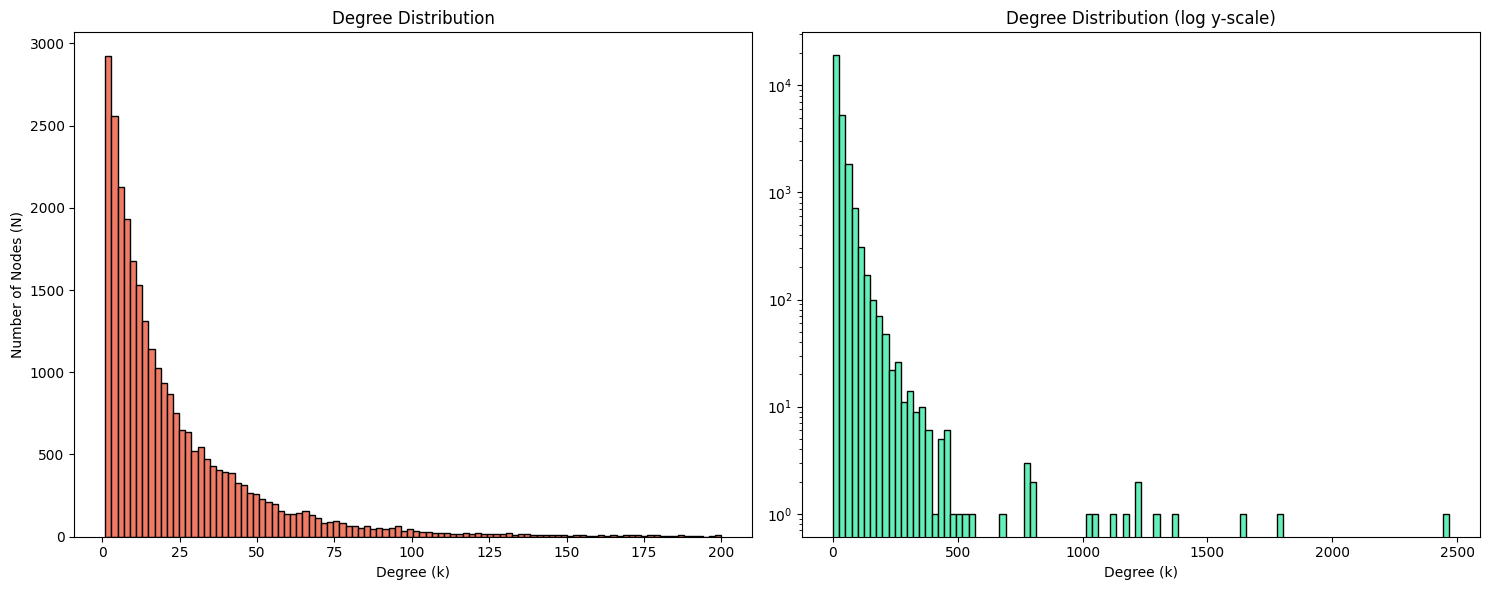

In [6]:
#Plot degree distribution
fig, ax = plt.subplots(1,2, figsize=(15, 6))
degree_sequence0 = [d for n, d in G.degree() if d<=200]
degree_sequence = [d for n, d in G.degree()]

ax[0].hist(degree_sequence0, bins=100, color='#F07B65', edgecolor='black')
ax[0].set_xlabel("Degree (k)")
ax[0].set_ylabel("Number of Nodes (N)")
ax[0].set_title("Degree Distribution")

ax[1].hist(degree_sequence, bins=100, color='#65EFB8', edgecolor='black')
ax[1].set_yscale('log')
ax[1].set_xlabel("Degree (k)")
ax[1].set_title("Degree Distribution (log y-scale)")

plt.tight_layout()
plt.show()

In [7]:
#power law fit
results = powerlaw.Fit(degree_sequence, discrete=True)
alpha = results.power_law.alpha
xmin = results.power_law.xmin
print(f"Alpha: {alpha}")
print(f"Xmin: {xmin}")
R, p = results.distribution_compare('power_law', 'exponential')
print(f"R: {R}")
print(f"p: {p}")

Calculating best minimal value for power law fit
Alpha: 3.1760678575019097
Xmin: 62.0
R: 356.5777046915072
p: 2.771460206197671e-08


<ipython-input-8-511d7fd38b1b>:12: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(degrees, fractions, 'bo-', markersize=3, color='blue', label='Fraction of Nodes')


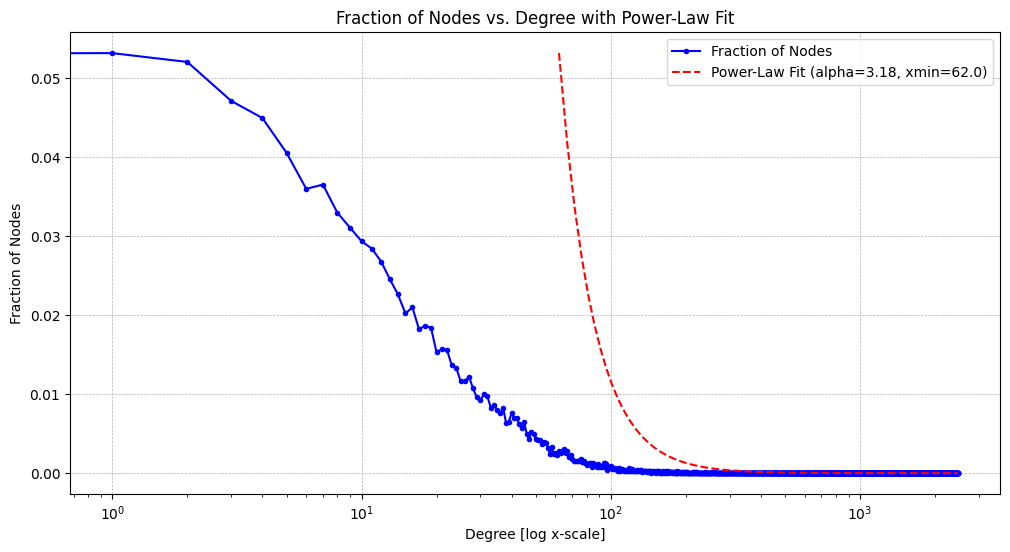

In [8]:
degree_counts = np.bincount(degree_sequence)
degrees = np.arange(len(degree_counts))
fractions = degree_counts / sum(degree_counts)

# Generate the power-law fit for the overlay
x = np.linspace(xmin, max(degrees), 500)
y = x ** (-alpha)
y = y * (max(fractions) / max(y))  # Scale to match the observed data

# Plot the degree vs. fraction of nodes
plt.figure(figsize=(12, 6))
plt.plot(degrees, fractions, 'bo-', markersize=3, color='blue', label='Fraction of Nodes')
plt.plot(x, y, 'r--', label=f'Power-Law Fit (alpha={alpha:.2f}, xmin={xmin})')

# Add title, labels, and legend
plt.title('Fraction of Nodes vs. Degree with Power-Law Fit')
plt.xlabel('Degree [log x-scale]')
plt.xscale('log')
plt.ylabel('Fraction of Nodes')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()


In [21]:
total_nodes = G.number_of_nodes()

#Nodes with degree less than Xmin(62)
nodes_less_than_xmin = sum(1 for d in degree_sequence if d < 89)
fraction_less_than_xmin = nodes_less_than_xmin / total_nodes

print(f"Total Nodes: {total_nodes}")
print(f"Nodes with degree < xmin: {nodes_less_than_xmin}")
print(f"Fraction of nodes with degree < xmin: {fraction_less_than_xmin:.4f}")

Total Nodes: 27770
Nodes with degree < xmin: 26655
Fraction of nodes with degree < xmin: 0.9598


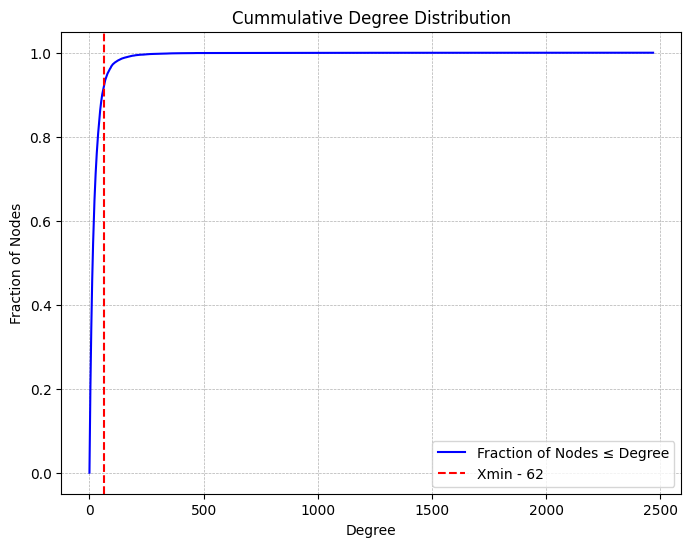

In [10]:
cumulative_counts = np.cumsum(degree_counts)
fraction_less_than_or_equal = cumulative_counts / total_nodes

# Plot the graph
plt.figure(figsize=(8, 6))
plt.plot(degrees, fraction_less_than_or_equal, 'b-', label='Fraction of Nodes â‰¤ Degree')
plt.axvline(x=xmin, color='r', linestyle='--', label='Xmin - 62')
plt.title('Cummulative Degree Distribution')
plt.xlabel('Degree')
plt.ylabel('Fraction of Nodes')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

#2.2 Degree Correlation

Correlation Coefficient: 0.2475



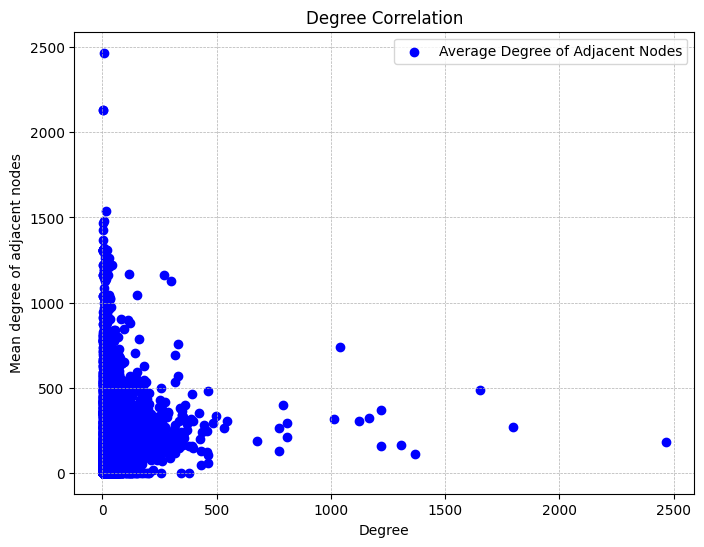

In [11]:
average_neighbor_degree = []

# Mean degree of adjacent nodes
for node in G.nodes():
    neighbors = list(G.neighbors(node))  # Get neighbors of the node
    if len(neighbors) > 0:
        avg_deg = np.mean([G.degree(neighbor) for neighbor in neighbors])  # Average degree of neighbors
    else:
        avg_deg = 0  # No neighbors, so average degree is 0
    average_neighbor_degree.append(avg_deg)

# Correlation coefficient
correlation = np.corrcoef(degree_sequence, average_neighbor_degree)[0, 1]
print(f"Correlation Coefficient: {correlation:.4f}")
print(f"")

# Plot
plt.figure(figsize=(8, 6))
plt.scatter(degree_sequence, average_neighbor_degree, color='b', label='Average Degree of Adjacent Nodes')
plt.title('Degree Correlation')
plt.xlabel('Degree')
plt.ylabel('Mean degree of adjacent nodes')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend()
plt.show()

#3. Centrality

#3.1 Betweenness Centrality

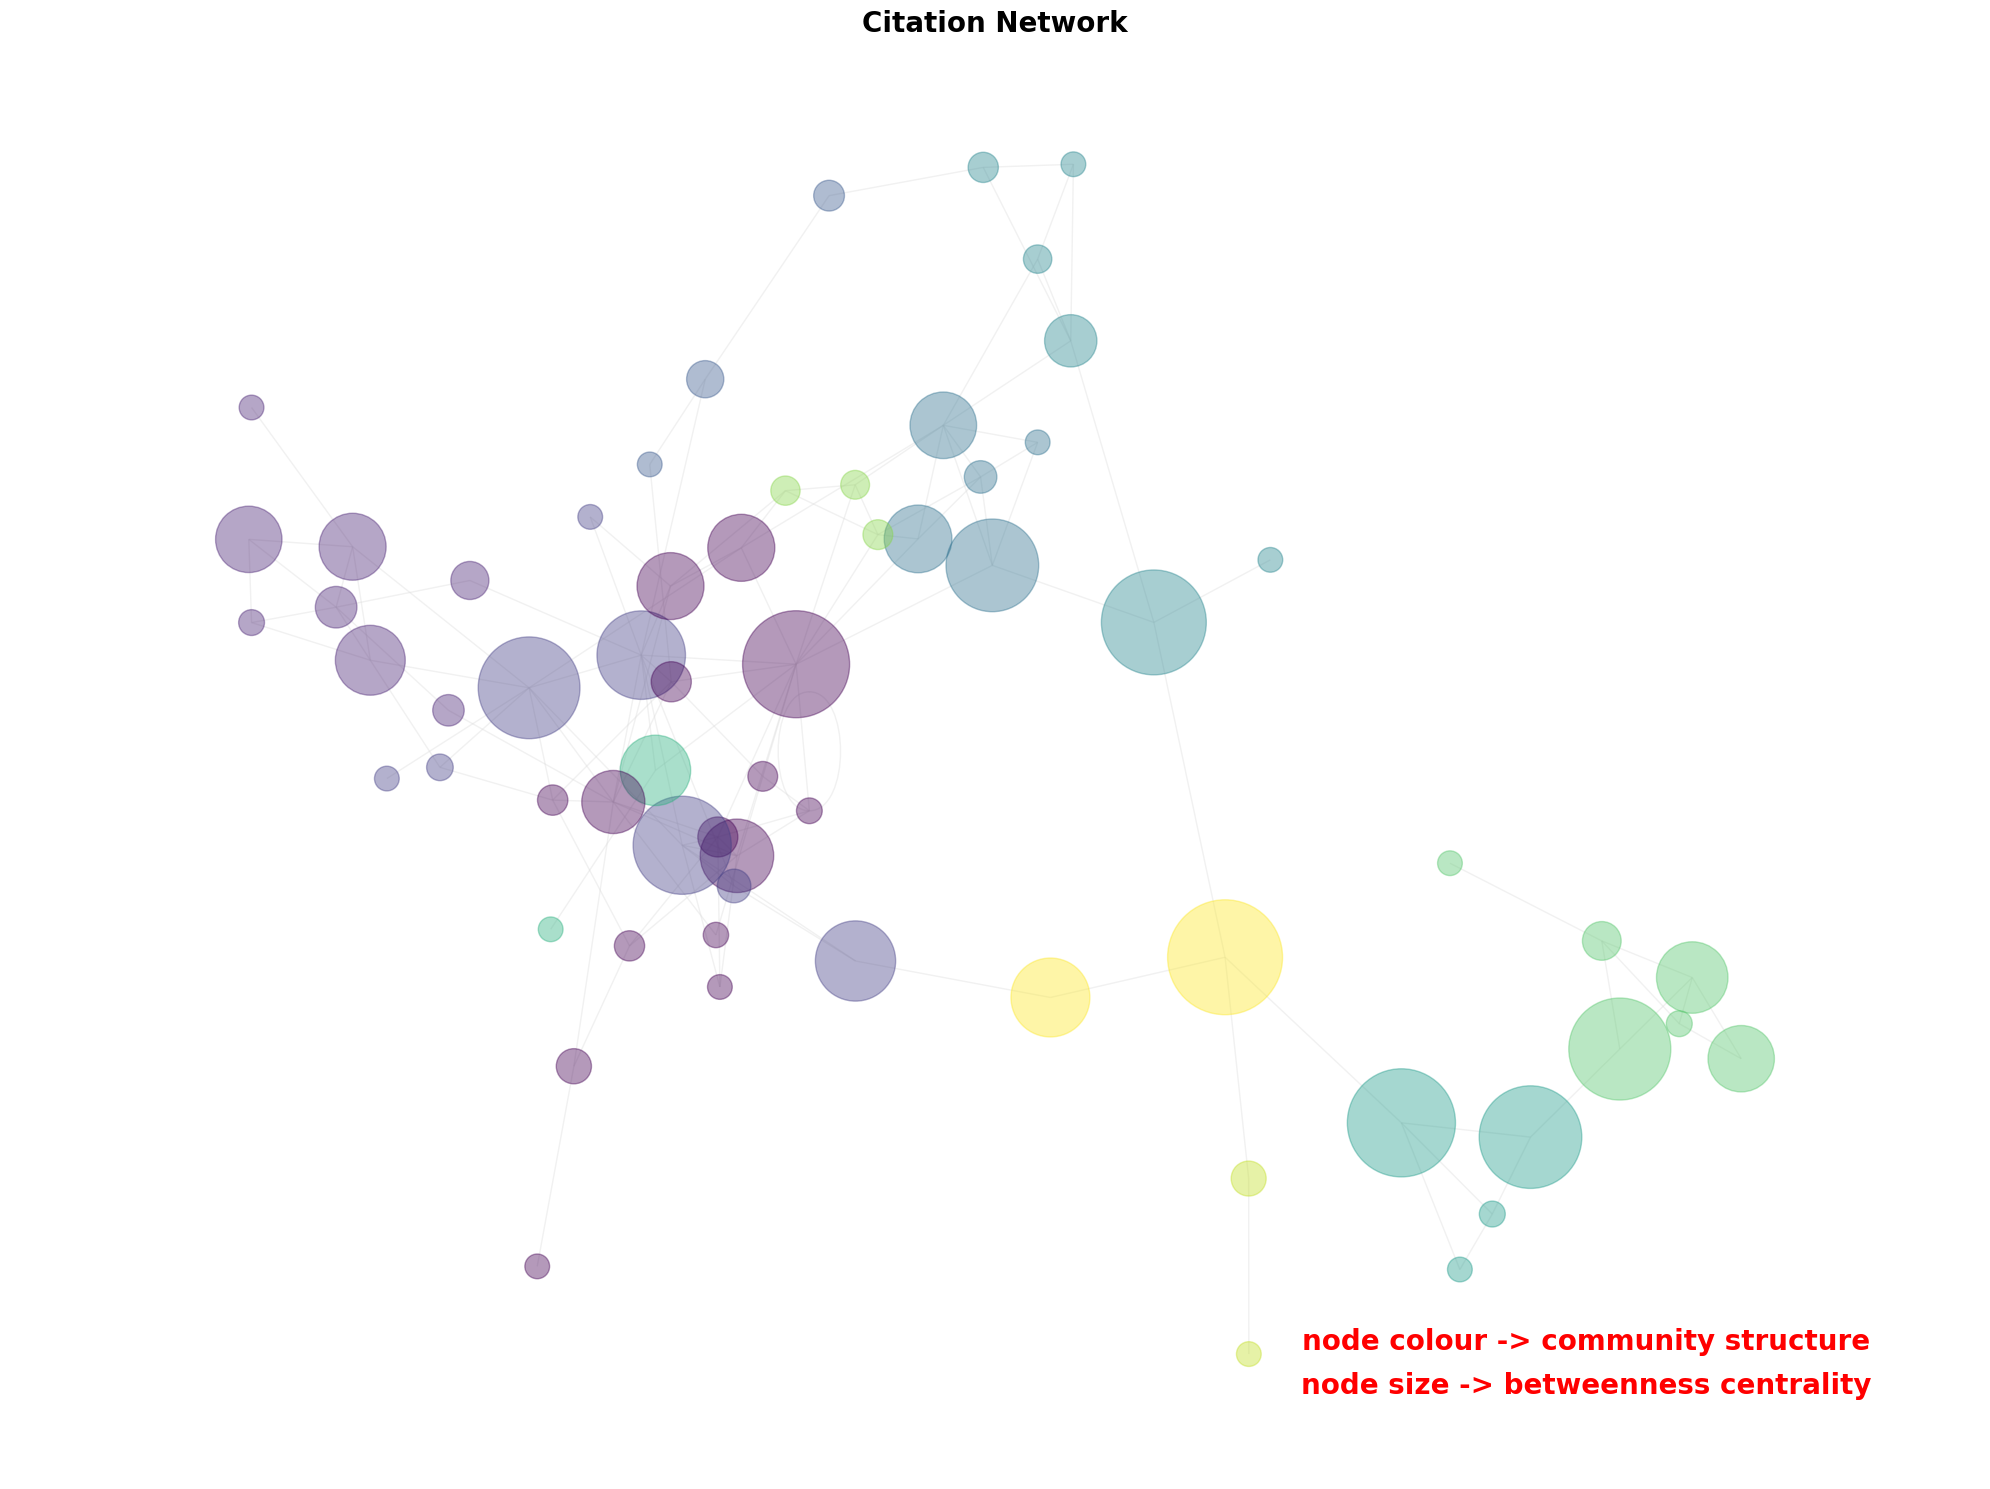

In [12]:
# largest connected component- betweenness centrality
components = nx.weakly_connected_components(betweeness_G)
largest_component = max(components, key=len)
H = betweeness_G.subgraph(largest_component)

# Convert H to an undirected graph
H = H.to_undirected() #This line converts the directed graph to undirected

# compute centrality
centrality = nx.betweenness_centrality(H, k=10, endpoints=True)

# compute community structure
lpc = nx.community.label_propagation_communities(H)
community_index = {n: i for i, com in enumerate(lpc) for n in com}

#### draw graph ####
fig, ax = plt.subplots(figsize=(20, 15))
pos = nx.spring_layout(H, k=0.15, seed=4572321)
node_color = [community_index[n] for n in H]
node_size = [v * 20000 for v in centrality.values()]
nx.draw_networkx(
    H,
    pos=pos,
    with_labels=False,
    node_color=node_color,
    node_size=node_size,
    edge_color="gainsboro",
    alpha=0.4,
)

# Title/legend
font = {"color": "k", "fontweight": "bold", "fontsize": 20}
ax.set_title("Citation Network", font)
# Change font color for legend
font["color"] = "r"

ax.text(
    0.80,
    0.09,
    "node colour -> community structure",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)
ax.text(
    0.80,
    0.06,
    "node size -> betweenness centrality",
    horizontalalignment="center",
    transform=ax.transAxes,
    fontdict=font,
)

# Resize figure for label readability
ax.margins(0.1, 0.05)
fig.tight_layout()
plt.axis("off")
plt.show()

#3.2 Indegree Centrality

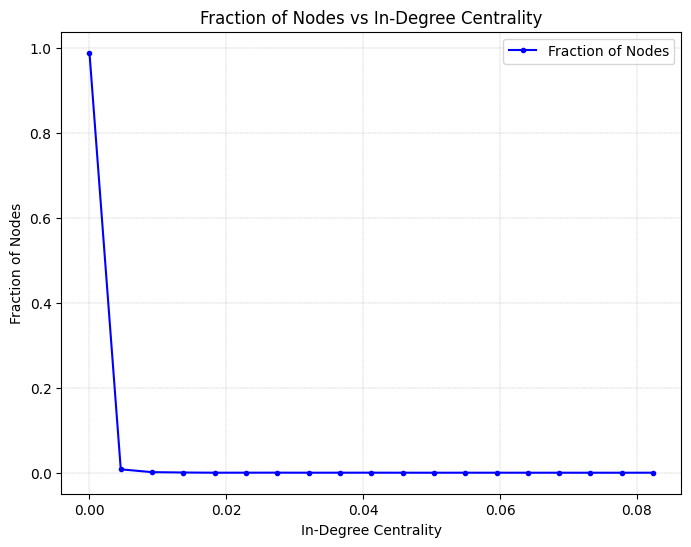

In [13]:
# Indegree Centrality
centrality = [G.in_degree(node) / (total_nodes - 1) for node in G.nodes()]
bins = np.linspace(0, max(centrality), 20)  # Divide centrality into 20 equal bins
hist, bin_edges = np.histogram(centrality, bins=bins)

# Calculate the fraction of nodes in each bin
fractions_bin = hist / total_nodes

# Plot the fraction of nodes vs centrality
plt.figure(figsize=(8, 6))
plt.plot(bin_edges[:-1], fractions_bin, 'bo-', markersize=3, label='Fraction of Nodes')
plt.title('Fraction of Nodes vs In-Degree Centrality')
plt.xlabel('In-Degree Centrality')
plt.ylabel('Fraction of Nodes')
plt.grid(True, linestyle='--', linewidth=0.3)
plt.legend()
plt.show()

In [14]:
# Nodes with descending centrality
centrality_dict = {node: G.in_degree(node) / (total_nodes - 1) for node in G.nodes()}
sorted_centrality = sorted(centrality_dict.items(), key=lambda x: x[1], reverse=True)
print("\nTop Nodes by Centrality:")
for node, value in sorted_centrality[:10]:  # Top 10 nodes
    print(f"Node {node}: Centrality = {value:.4f}")


Top Nodes by Centrality:
Node 9711200: Centrality = 0.0869
Node 9802150: Centrality = 0.0639
Node 9802109: Centrality = 0.0591
Node 9407087: Centrality = 0.0468
Node 9610043: Centrality = 0.0432
Node 9510017: Centrality = 0.0416
Node 9908142: Centrality = 0.0412
Node 9503124: Centrality = 0.0401
Node 9906064: Centrality = 0.0372
Node 9408099: Centrality = 0.0362


#4. Cascading Effects

---



#4.1 Model

In [15]:
def node_removal(G, target_node):
    """
    Removes a target node and all nodes that cites the node
    (those connected by outward connections).

    Args:
    - G: Directed network
    - target_node: Node to be removed initially

    Returns:
    - new_G: Updated network after the chain reaction
    - final_node_count: Total nodes after chain reaction

    """
    nodes_to_remove = {target_node}
    removed_nodes = set()

    while nodes_to_remove:
        current_node = nodes_to_remove.pop()
        if current_node not in removed_nodes:
            removed_nodes.add(current_node)
            # Add all nodes that have an outgoing edge to the current node
            nodes_to_remove.update(list(G.predecessors(current_node)))

    # Create a new network excluding the removed nodes
    new_G = G.copy()
    new_G.remove_nodes_from(removed_nodes)

    return new_G, len(removed_nodes)

    """target_node = 9711200  # Specify the node to start the chain reaction
new_G1, nodes_removed = node_removal(G, target_node)

print(f"Original number of nodes: {total_nodes}")
print(f"Final number of nodes after chain reaction: {total_nodes-nodes_removed}")
print(f"Nodes removed: {nodes_removed}")"""

In [16]:
def network_residual(n):
  target_centrality_nodes = sorted(centrality_dict, key=centrality_dict.get, reverse=True)[:n]
  nodesremoved_G = G.copy()
  # Perform chain reaction removal for each of the top 5 nodes dynamically
  """print(f"Original Number of Nodes: {total_nodes}\n")"""
  for target_node in target_centrality_nodes:
      if nodesremoved_G.has_node(target_node):  # Check if the node still exists in the graph
        nodesremoved_G, nodes_removed = node_removal(nodesremoved_G, target_node)
        new_count = nodesremoved_G.number_of_nodes()
        # print(f"Target Node: {target_node}")
        # print(f"Nodes Removed in Chain Reaction: {nodes_removed}")
        # print(f"Remaining Nodes: {new_count}\n")
      else:
        nodesremoved_G=nodesremoved_G
        # print(f"Target Node: {target_node} was already removed.\n")

  # print(f"Final Number of Nodes After All Removals: {nodesremoved_G.number_of_nodes()}")
  # print(f"Total Nodes Removed: {total_nodes - nodesremoved_G.number_of_nodes()}")
  return nodesremoved_G.number_of_nodes()/total_nodes

#4.2 Impact on Key Nodes

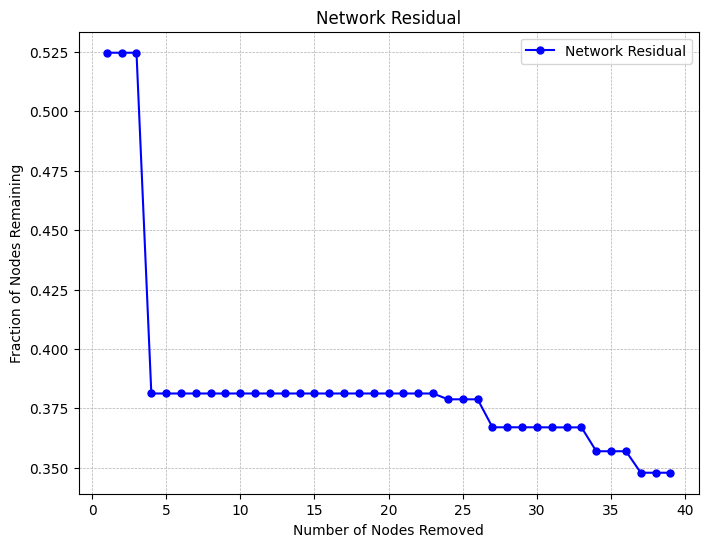

In [17]:
n_values = list(range(1,40))
residuals = [network_residual(n) for n in n_values]

# Plot the network residual
plt.figure(figsize=(8, 6))
plt.plot(n_values, residuals, 'bo-', markersize=5, label='Network Residual')
plt.title('Network Residual')
plt.xlabel('Number of Nodes Removed')
plt.ylabel('Fraction of Nodes Remaining')
plt.grid(True, linestyle='--', linewidth=0.5)
plt.legend(fontsize=10)
plt.show()


#5. Temporal Analysis

---



In [18]:
attribute_data = pd.read_csv(attribute_path, sep='\t', names=['Node ID', 'Year'], skiprows=1)

def G_Year(y): #y<2003
    """
    Function to generate a directed graph until a given year from the original network G.

    Args:
    - y: Network until the specified year.

    Returns:
    - G_filtered: A new graph filtered for the given year range.
    """

    year_range = tuple(str(year) for year in range(1992, y + 1))

    # Filter the DataFrame where 'Year' starts with any of the years in year_range
    filtered_data = attribute_data[attribute_data['Year'].astype(str).str.startswith(tuple(year_range))]

    # Extract 'Node ID' from filtered data and store them in a list
    nodes_filtered = filtered_data['Node ID'].tolist()

    # Create a copy of the original graph G to work with
    G_filtered = G.copy()

    # Remove nodes from the graph that are not in nodes_filtered
    nodes_to_remove = [node for node in G_filtered.nodes() if node not in nodes_filtered]
    G_filtered.remove_nodes_from(nodes_to_remove)

    return G_filtered

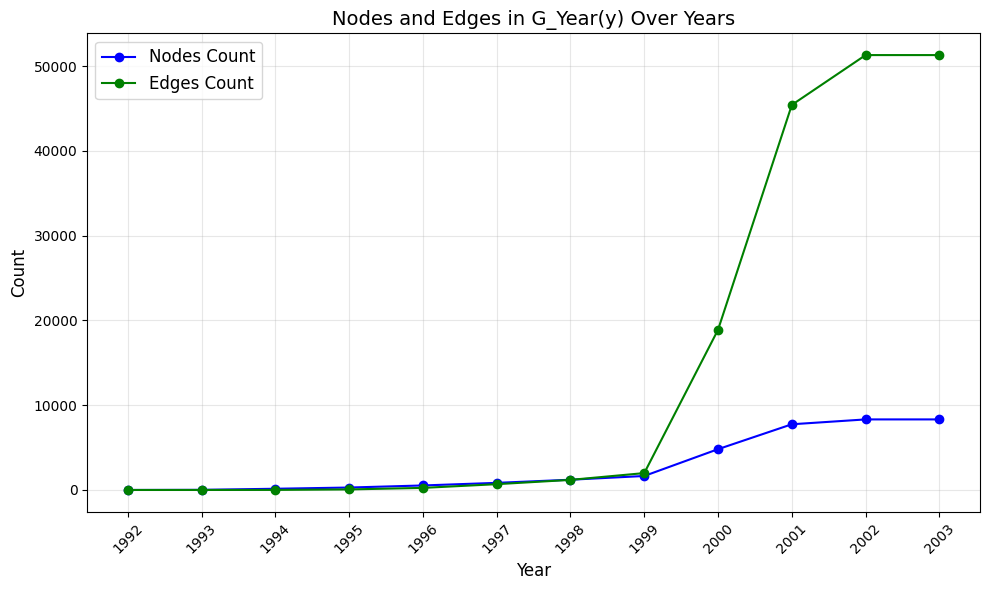

In [19]:
year_range = range(1992, 2003 + 1)

# Lists to store the count of nodes and edges for each year
nodes_count = []
edges_count = []

# Iterate over the year range and calculate the nodes and edges for each year
for year in year_range:
    G_plot = G_Year(year)
    nodes_count.append(G_plot.number_of_nodes())
    edges_count.append(G_plot.number_of_edges())

# Plotting the results
plt.figure(figsize=(10, 6))

# Plot nodes count
plt.plot(year_range, nodes_count, marker='o', label='Nodes Count', color='blue')

# Plot edges count
plt.plot(year_range, edges_count, marker='o', label='Edges Count', color='green')

# Adding labels and title
plt.xlabel('Year', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.title('Nodes and Edges in G_Year(y) Over Years', fontsize=14)
plt.xticks(year_range, rotation=45)
plt.grid(alpha=0.3)
plt.legend(fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()

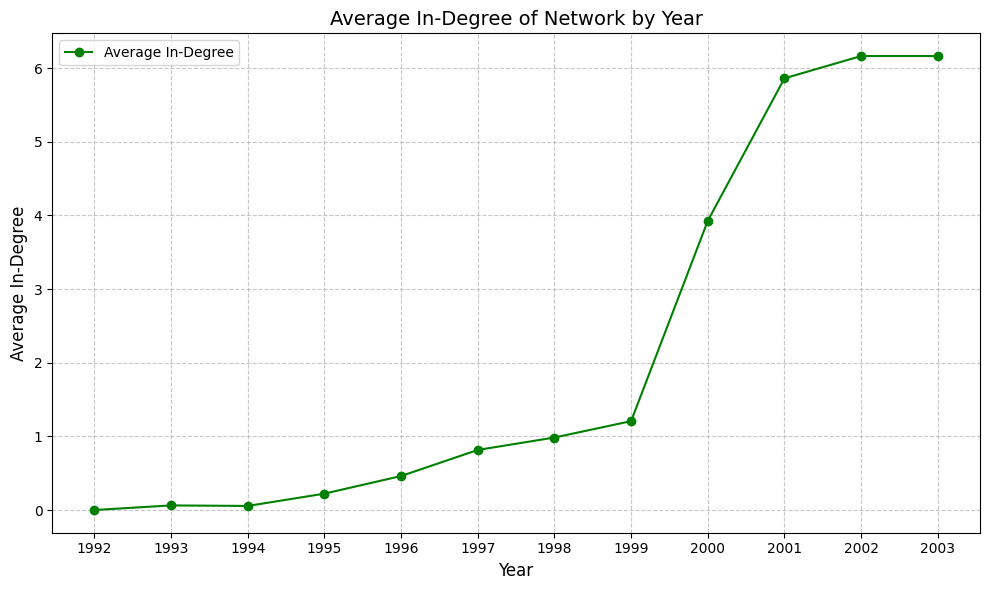

In [20]:
average_indegrees = []
years = range(1992, 2003 + 1)

# Calculate the average in-degree for each year
for year in years:
    # Generate the graph for the given year
    G_filtered = G_Year(year)

    # Calculate total nodes
    total_nodes = G_filtered.number_of_nodes()

    # Calculate total in-degree (sum of in-degrees of all nodes)
    total_in_degree = sum(dict(G_filtered.in_degree()).values())

    # Avoid division by zero
    avg_in_degree = total_in_degree / total_nodes if total_nodes > 0 else 0

    # Store the results
    average_indegrees.append(avg_in_degree)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(years, average_indegrees, marker='o', linestyle='-', color='g', label='Average In-Degree')
plt.title('Average In-Degree of Network by Year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Average In-Degree', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(years)
plt.legend()
plt.tight_layout()
plt.show()